In [1]:
cd ..

/home/martinsevilla/langevin_ggm


In [2]:
from ggm_estimation.utils.graph_generation import generate_ergm

In [3]:
As = generate_ergm(15, [0.7, -2.0], 10, seed_r=0)

R[write to console]: Loading required package: network

R[write to console]: 
‘network’ 1.18.1 (2023-01-24), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


R[write to console]: 
‘ergm’ 4.4.0 (2023-01-26), part of the Statnet Project
* ‘news(package="ergm")’ for changes since last version
* ‘citation("ergm")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


R[write to console]: ‘ergm’ 4 is a major update that introduces some backwards-incompatible
changes. Please type ‘news(package="ergm")’ for a list of major
changes.




In [3]:
import joint_langevin.ergm.statistics as st
import joint_langevin.ergm.tools as et
import joint_langevin.model.link_predictor_v2 as lp2
import joint_langevin.utils.matrix_operations as mtx

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
from scipy.stats import wishart
from functools import partial
from notebooks.format_results import compute_accuracy_best_threshold, plot_results

np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 2

#### See plots

232


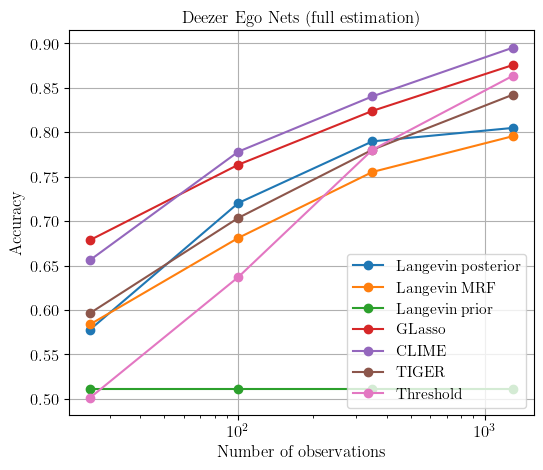

In [3]:
output_file = "outputs/deezer_clime_all_missing.csv"
th, acc = compute_accuracy_best_threshold(output_file, 
                                          ["langevin_posterior", "langevin_mrf", "langevin_prior", 
                                           "glasso", "clime", "tiger", "threshold_variable"], 
                                          grid_size=50,
                                          metric="auc")
labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_mrf": "Langevin likelihood",
    "langevin_prior": "Langevin prior",
    "glasso": "GLasso",
    "clime": "CLIME",
    "threshold_variable": "Threshold",
    "tiger": "TIGER",
}
plot_results(acc, labels, "Deezer Ego Nets (full estimation)", "plots/deezer_ego_full.pdf")

360
348
392


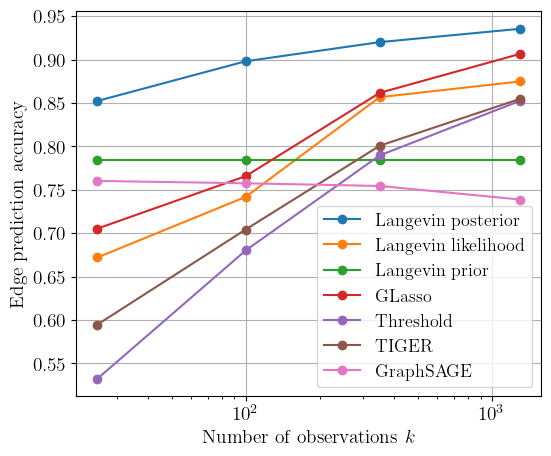

In [4]:
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize

output_file = "outputs/deezer_ego.csv"
th, acc = compute_accuracy_best_threshold(output_file, ["langevin_posterior", "langevin_mrf", "langevin_prior", "cvx"], grid_size=50)

output_file = "outputs/deezer_benchmarks.csv"
th, acc_bench = compute_accuracy_best_threshold(output_file, ["threshold_fixed", "tiger"], grid_size=50)

output_file = "outputs/deezer_benchmarks_sage.csv"
th, acc_bench_sage = compute_accuracy_best_threshold(output_file, ["gnn"], grid_size=500)

all_accs = {
    **acc, **acc_bench, **acc_bench_sage
}
# all_accs = {**acc, **acc_bench, **acc_bench_sage}
labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_mrf": "Langevin likelihood",
    "langevin_prior": "Langevin prior",
    "cvx": "GLasso",
    "clime": "CLIME",
    "threshold_fixed": "Threshold",
    "threshold_variable": "Threshold manual",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}
plot_results(all_accs, labels, "", "plots/deezer_ego.pdf")

160
172


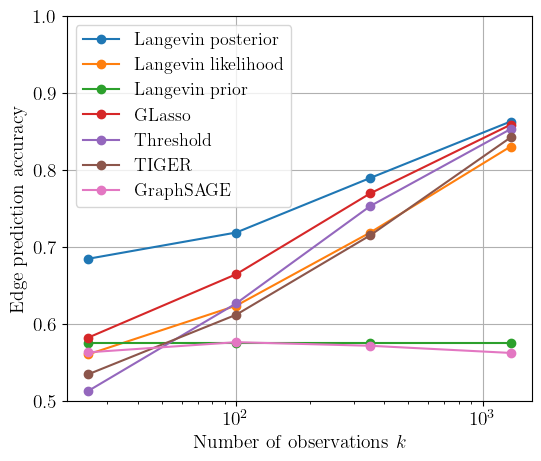

In [8]:
th, acc = compute_accuracy_best_threshold("outputs/barabasi_albert_diff_nodes_final.csv", 
                                          ["langevin_posterior", "langevin_mrf", "langevin_prior", "cvx"],
                                           [5000],
                                           50)

th, acc_bench = compute_accuracy_best_threshold("outputs/barabasi_benchmarks.csv", ["threshold_fixed", "tiger", "gnn"], grid_size=100)

all_accs = {
    **acc, **acc_bench
}
labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_mrf": "Langevin likelihood",
    "langevin_prior": "Langevin prior",
    "cvx": "GLasso",
    "clime": "CLIME",
    "threshold_fixed": "Threshold",
    "threshold_variable": "Threshold manual",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}
plot_results(all_accs, labels, "", "plots/barabasi_albert.pdf",
             ylims=(0.5, 1.00))

104


200
200
200
200
200
204


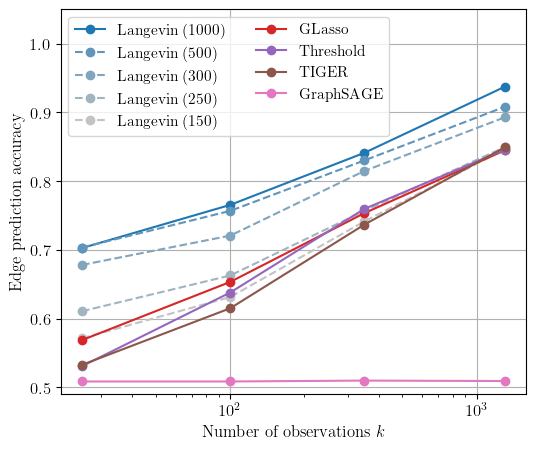

In [6]:
def color_fader(c1, c2, mix=0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1 - mix) * c1 + mix * c2)

num_samples_models = [150, 250, 300, 500, 1000]
labels = {f"{num_samples}_langevin_posterior": f"Langevin ({num_samples})" for num_samples in num_samples_models}
labels.update({
    "cvx": "GLasso",
    "clime": "CLIME",
    "threshold_fixed": "Threshold",
    "threshold_variable": "Threshold manual",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
})

all_accs = dict()
for num_samples in num_samples_models[::-1]:
    th, acc = compute_accuracy_best_threshold(f"outputs/ergm_gnn_{num_samples}.csv",
                                              ["langevin_posterior"],
                                              [5000],
                                              50)
    all_accs.update({f'{num_samples}_{k}': v for k, v in acc.items()})

th, acc_glasso = compute_accuracy_best_threshold("outputs/ergm_closed_form.csv", 
                                          ["cvx"],
                                           [5000],
                                           50)

th, acc_bench = compute_accuracy_best_threshold("outputs/ergm_benchmarks.csv", ["threshold_fixed", "tiger", "gnn"], grid_size=100)
all_accs = {
    **all_accs, **acc_glasso, **acc_bench
}
colors = {
    "cvx": '#d62728',
    "1000_langevin_posterior": '#1f77b4',
    **{f"{num_samples}_langevin_posterior": color_fader('#c3c3c3', '#1f77b4', mix=i/(len(num_samples_models))) for i, num_samples in enumerate(num_samples_models[:-1])},
    "cvx": "#d62728",
    # "clime": '#9467bd',
    "threshold_fixed": "#9467bd",
    "tiger": "#8c564b",
    "gnn": "#e377c2",
}

linestyles = {
    "1000_langevin_posterior": '-',
    **{f"{num_samples}_langevin_posterior": '--' for num_samples in num_samples_models[:-1]},
    "cvx": "-",
    "clime": '-',
    "threshold_fixed": "-",
    "tiger": "-",
    "gnn": "-",
}
plot_results(all_accs, labels, title="", colors=colors, linestyles=linestyles, output_file="plots/ergm.pdf",
             legend_loc="upper left", ylims=(0.49, 1.05), legend_ncol=2)

264


400


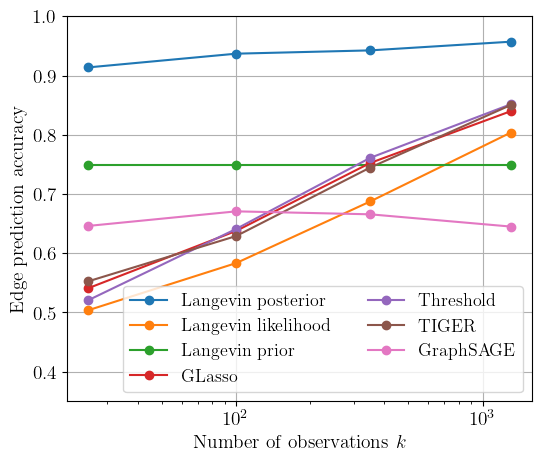

In [11]:
th, acc = compute_accuracy_best_threshold("outputs/final_grids_link_prediction_[25, 100, 350, 1300, 5000]_30_seed_456_quic_linearfit_10_samples_threshold_linearfit.csv", 
                                          ["langevin_posterior", "langevin_mrf", "langevin_prior"],
                                           [5000],
                                           50)
th, acc_bench = compute_accuracy_best_threshold("outputs/grids_benchmarks.csv", ["cvx", "threshold_fixed", "tiger", "gnn"], grid_size=100)

all_accs = {
    **acc, **acc_bench
}
labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_mrf": "Langevin likelihood",
    "langevin_prior": "Langevin prior",
    "cvx": "GLasso",
    "clime": "CLIME",
    "threshold_fixed": "Threshold",
    "threshold_variable": "Threshold manual",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}

plot_results(all_accs, labels, "", "plots/grids.pdf", legend_ncol=2, legend_loc="lower right",
             ylims=(0.35, 1.00))

460


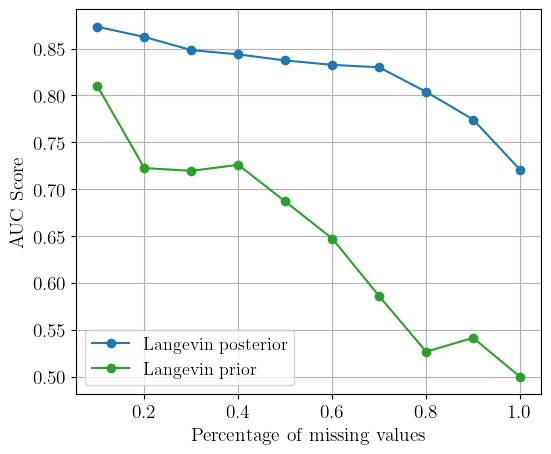

In [12]:
th, acc = compute_accuracy_best_threshold("outputs/deezer_diff_missing.csv", 
                                          ["langevin_posterior", "langevin_prior"],
                                          grid_size=50,
                                          col_x_axis="nans",
                                          remove_num_obs=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55],
                                          metric="auc")
labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_prior": "Langevin prior",
}

colors = {
    "langevin_prior": '#2ca02c',
    "langevin_posterior": '#1f77b4',
}

plot_results(acc, labels, "", "plots/deezer_diff_missing.pdf", 
             xlabel="Percentage of missing values", ylabel="AUC Score", colors=colors, logscale=False)

#### Configuration

In [4]:
# Graph parameters
num_nodes = 50
thetas = [0.7, -2.0]
global_statistics_r = [f"altkstar({st.LAMBDA_}, fixed=TRUE)", "edges"]
global_statistics_py = ["altkstar", "edges"]

# GMRF parameters
num_obs = 25
prior_Theta = wishart(num_nodes, np.eye(num_nodes) * 10 / num_nodes)

# Simulation parameters
n_sim = 100
nans = 30
one_zero_ratio = 0.5
n_proportional = False
seed = 400 # np.random.randint(0, 1000)
psd_trials = 10

#### Data creation

In [5]:
graphs = et.generate_matrices(num_nodes, thetas, n_sim, global_statistics_r, num_attr=0, seed_r=seed)
I = np.eye(num_nodes)

def simulate_data(A, n_obs):
    a = mtx.adj_matrix_to_vec(A)
    a_nan = mtx.random_nan_replacement(a, nans, one_zero_ratio=one_zero_ratio, n_proportional=n_proportional)
    A_obs = mtx.vec_to_adj_matrix(a_nan)
    Theta = prior_Theta.rvs() * (A + I)
    _ = np.linalg.cholesky(Theta)

    trials = 0
    while trials < psd_trials:
        try:
            Theta = prior_Theta.rvs() * (A + I)
            # If this fails, it is because Theta is not PSD
            _ = np.linalg.cholesky(Theta)
            break
        except np.linalg.LinAlgError:
            print(f"Not PSD matrix. Trying again.")
            pass
        trials += 1
    if trials == psd_trials:
        raise RuntimeError("Could not generate a PSD matrix.")

    inv_Theta = np.linalg.inv(Theta)
    X_obs = np.random.multivariate_normal(np.zeros(num_nodes), inv_Theta, size=n_obs)
    return A_obs, X_obs, Theta

R[write to console]: Loading required package: network

R[write to console]: 
‘network’ 1.18.1 (2023-01-24), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


R[write to console]: 
‘ergm’ 4.4.0 (2023-01-26), part of the Statnet Project
* ‘news(package="ergm")’ for changes since last version
* ‘citation("ergm")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


R[write to console]: ‘ergm’ 4 is a major update that introduces some backwards-incompatible
changes. Please type ‘news(package="ergm")’ for a list of major
changes.




#### Simulations

In [6]:
# Langevin predictor
sigmas = np.linspace(0.5, 0.03, 10)
epsilon = 1.0E-6
steps = 300
prior_A_score = partial(et.score_annealed_posterior, thetas=thetas, st_funs=global_statistics_py)
langevin_predictor = lp2.LangevinLinkPredictor(sigmas=sigmas,
                                               epsilon=epsilon,
											   steps=steps,
											   score_estimator=prior_A_score)

# CVXPY predictor
zero_tol = 9.0E-4
lambda_ = 2.25 * 2 / num_obs
cvxpy_predictor = lp2.ConvexLinkPredictor(zero_tol)

# Non-convex predictor
optimizer = torch.optim.Adam
learning_rate = 0.01
epochs = 1000
nonconvex_predictor = lp2.NonConvexLinkPredictor(optimizer, learning_rate, epochs, thetas)

# QUIC predictor
lambda_fun = lambda n: - 0.00325 * np.log(n) + 0.03
quic_predictor = lp2.QuicLinkPredictor(lambda_fun)

In [7]:
idx = 14
A_obs, X_obs, Theta = simulate_data(graphs[idx]["A"], num_obs)
S = np.cov(X_obs, rowvar=False, ddof=0)
missing_idx = np.where(np.isnan(np.triu(A_obs)))
graphs[idx]["A"][missing_idx]

array([0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.])

In [59]:
A_langevin = langevin_predictor.generate_sample(A_obs, X_obs)

Best accuracy for lambda =  0.004084238652674522


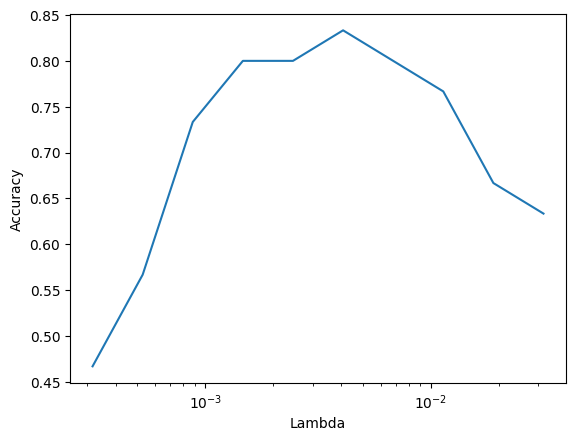

In [60]:
# A_cvx, Theta_cvx = cvxpy_predictor.generate_sample(A_obs, S, 0.005, return_theta=True)
# Theta_cvx[missing_idx]

lams = np.logspace(-3.5, -1.5, 10)
A_cvx_list, accuracies = [], []
for lam in lams:
    A_cvx, Theta_cvx = cvxpy_predictor.generate_sample(A_obs, S, lam, return_theta=True)
    A_cvx_list.append(A_cvx)
    # Thetas_cvx.append(Theta_cvx)
    # posterior = lp2.compute_log_posterior_numpy(A_cvx, S, num_obs, Theta_cvx, thetas, st.LAMBDA_)
    accuracies.append((graphs[idx]["A"][missing_idx] == A_cvx[missing_idx]).mean())

print("Best accuracy for lambda = ", lams[np.argmax(accuracies)])
A_cvx = A_cvx_list[np.argmax(accuracies)]
# Plot accuracy vs lambda, logarithmic axes in X
plt.plot(lams, accuracies)
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

Best accuracy for lambda =  0.0021117830444482445


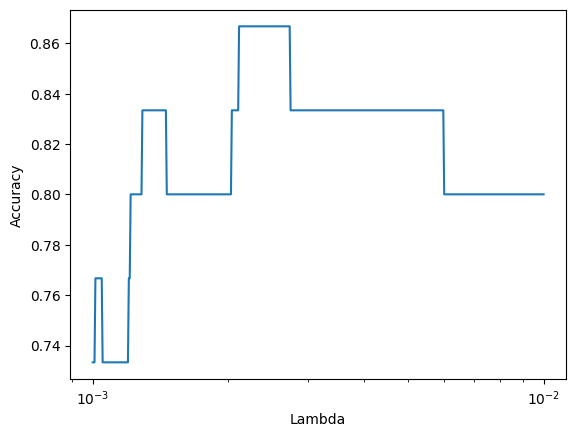

In [73]:
from inverse_covariance import QuicGraphicalLasso

idx = 14
A_obs, X_obs, Theta = simulate_data(graphs[idx]["A"], num_obs)
missing_idx = np.where(np.isnan(np.triu(A_obs)))
graphs[idx]["A"][missing_idx]

lams = np.logspace(-3, -2, 500)

diag_idxs = np.diag_indices_from(A_obs)
mask_inf_penalty = A_obs == 0
mask_inf_penalty[diag_idxs] = False
mask_unknown = np.isnan(A_obs)

Lambda = np.zeros(A_obs.shape)
# The "infinite penalty" should not be ridiculously high
# Otherwise the algorithm becomes numerically unstable
# (Before I was using np.inf and it wasn't working properly)
Lambda[mask_inf_penalty] = 10000

A_quic_list, accuracies = [], []
for lam in lams:
    Lambda[mask_unknown] = lam
    model = QuicGraphicalLasso(
        lam=Lambda,  # Graphical lasso penalty (scalar or matrix) 
        # mode=str,               # 'default': single estimate
        #                         # 'path': use sequence of scaled penalties 
        # path=list,              # Sequence of penalty scales mode='path'
        init_method="cov",        # Initial covariance estimate: 'corrcoef' or 'cov'
        auto_scale=False,        # If True, scales penalty by 
                                # max off-diagonal entry of the sample covariance
    )
    Theta_quic = model.fit(X_obs).precision_
    A_quic = (np.abs(Theta_quic - np.diag(np.diag(Theta_quic))) != 0.0).astype(float)
    A_quic_list.append(A_quic)
    # posterior = lp2.compute_log_posterior_numpy(A_quic, S, num_obs, Theta_quic, thetas, st.LAMBDA_)
    accuracies.append((graphs[idx]["A"][missing_idx] == A_quic[missing_idx]).mean())
A_quic = A_quic_list[np.argmax(accuracies)]
print("Best accuracy for lambda = ", lams[np.argmax(accuracies)])
# Plot accuracy vs lambda, logarithmic axes in X
plt.plot(lams, accuracies)
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

In [62]:
Theta[missing_idx]

array([ 1.15147478,  0.        , -0.        ,  0.40052975, -0.        ,
        0.        , -0.        , -1.37625638,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.16124222, -0.        ,
        0.        ,  1.17398543,  0.        ,  0.        , -0.74949186,
       -0.09335132,  0.        , -1.02546495, -0.08946089,  0.        ,
        0.        , -0.11402268, -0.11985534,  0.        , -0.        ])

In [63]:
# A_quic, Theta_quic = quic_predictor.generate_sample(A_obs, X_obs, return_theta=True)

In [64]:
A_noncvx = nonconvex_predictor.generate_sample(A_obs, X_obs, track=False)

In [74]:
missing_idx = np.where(np.isnan(np.triu(A_obs)))
A_langevin_posterior = A_langevin["both"]
A_langevin_prior = A_langevin["prior"]
A_langevin_likelihood = A_langevin["mrf"]
print("Langevin accuracy (posterior):", (graphs[idx]["A"][missing_idx] == A_langevin_posterior[missing_idx]).mean())
print("Langevin accuracy (prior):", (graphs[idx]["A"][missing_idx] == A_langevin_prior[missing_idx]).mean())
print("Langevin accuracy (likelihood):", (graphs[idx]["A"][missing_idx] == A_langevin_likelihood[missing_idx]).mean())
print("CVX accuracy:", (graphs[idx]["A"][missing_idx] == A_cvx[missing_idx]).mean())
print("QUIC accuracy:", (graphs[idx]["A"][missing_idx] == A_quic[missing_idx]).mean())
print("Non-convex accuracy:", (graphs[idx]["A"][missing_idx] == A_noncvx[missing_idx]).mean())

Langevin accuracy (posterior): 0.6333333333333333
Langevin accuracy (prior): 0.7666666666666667
Langevin accuracy (likelihood): 0.6333333333333333
CVX accuracy: 0.8333333333333334
QUIC accuracy: 0.8666666666666667
Non-convex accuracy: 0.5666666666666667


#### Tuning

In [4]:
df_mean_samples = pd.read_csv("outputs/tuning_langevin_mean_sample.csv", sep=";", index_col=0)
df_mean_samples["real_values"] = df_mean_samples["real_values"].apply(lambda x: np.array(eval(x)))
df_mean_samples["predicted_values"] = df_mean_samples["predicted_values"].apply(lambda x: np.array(eval(x)))

Used samples: 94


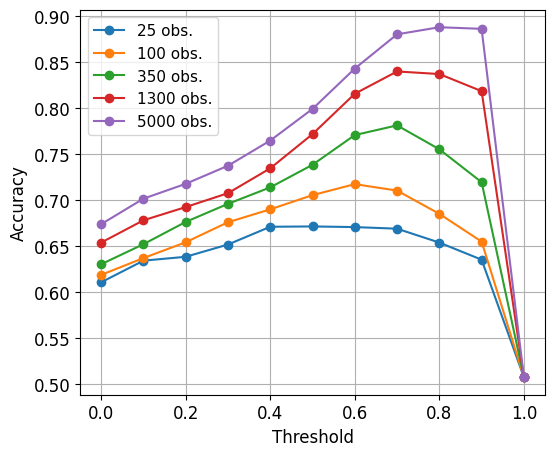

In [6]:
thresholds = np.linspace(0, 1, 11)

accuracy_per_threshold = []
for th in thresholds:
    df_mean_agg = df_mean_samples.groupby(["realization_n", "num_obs"])[["real_values", "predicted_values"]].mean()
    df_mean_agg["predicted_values_th"] = df_mean_agg["predicted_values"].apply(lambda x: (x > th).astype(float))

    accuracies = df_mean_agg.apply(lambda row: np.mean(row["predicted_values_th"] == row["real_values"]), axis=1).to_frame().groupby(["num_obs"]).mean()
    accuracy_per_threshold.append(accuracies.to_dict()[0])
# Conver the list of dicts to a dict of lists
accuracy_per_threshold = {k: [dic[k] for dic in accuracy_per_threshold] for k in accuracy_per_threshold[0]}

print("Used samples:", df_mean_samples.realization_n.max())

for num_obs, accuracies in accuracy_per_threshold.items():
    plt.plot(thresholds, accuracies, label=f"{num_obs} obs.", marker="o")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

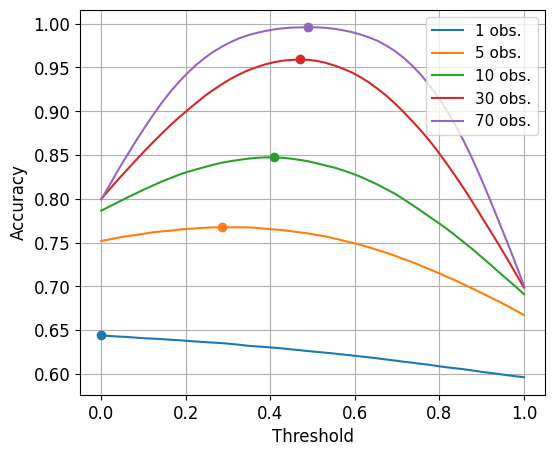

In [142]:
sigma = 10.0
dim = 50
thresholds = np.linspace(0, 1, 50)
num_obs = [1, 5, 10, 30, 70]
realizations = 5000
num_samples = 4

true_mean = np.repeat([0, 1, 1, 1, 0], dim / 5)
for n in num_obs:
    measurements = np.random.multivariate_normal(true_mean, sigma * np.eye(len(true_mean)), size=(realizations, num_samples, n))
    samples = measurements.mean(axis=2)
    mean_samples = samples.mean(axis=1)
    # projected_mean_sample = np.clip(mean_sample, 0, 1).round()
    # Compute accuracy for each threshold
    accuracies = []
    for th in thresholds:
        # predicted = (projected_mean_sample > th).astype(float)
        predicted = (mean_samples > th)
        accuracies.append((predicted == true_mean).mean(axis=1).mean())
    accuracies = np.array(accuracies)
    plt.plot(thresholds, accuracies, label=f"{n} obs.")
    # Plot a dot in the maximum for each curve, with the same color as the curve
    plt.plot(thresholds[np.argmax(accuracies)], accuracies.max(), "o", color=plt.gca().lines[-1].get_color())
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

In [22]:
# Curve fitting
def func(x, a, b):
    # return a * (1 - np.exp(- np.log(x) / b))
    return a + b * np.log(x)

popt, pcov = curve_fit(func, list(accuracy_per_threshold.keys()), theoretical_thresholds)
print(popt)

[0.25380303 0.07596318]


[25, 100, 350, 1300, 5000]
[0.5, 0.6000000000000001, 0.7000000000000001, 0.7000000000000001, 0.8]


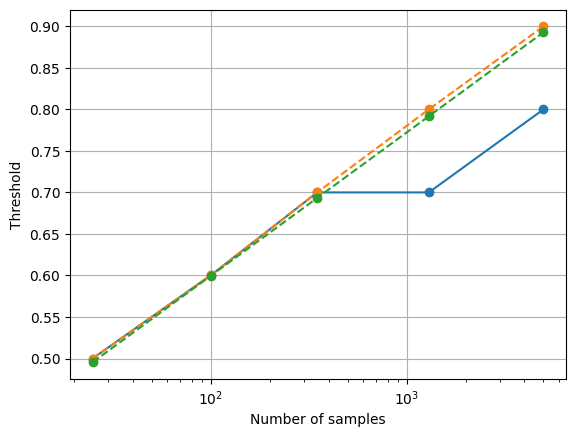

In [23]:
print(list(accuracy_per_threshold.keys()))
print([thresholds[np.argmax(accuracies)] for accuracies in accuracy_per_threshold.values()])

# theoretical_thresholds = [0.4, 0.6, 0.7, 0.75, 0.8]
theoretical_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
num_obs_list = np.array([25, 100, 350, 1300, 5000])
# Plot the threshold where the accuracy is maximum for each num_obs
plt.plot(num_obs_list, [thresholds[np.argmax(accuracies)] for accuracies in accuracy_per_threshold.values()], marker="o")
plt.plot(num_obs_list, theoretical_thresholds, "--", marker="o")
# plt.plot(num_obs_list, 0.84 - 1.74 * num_obs_list ** (- 0.43), "--", marker="o")
plt.plot(num_obs_list, 0.254 + 0.075 * np.log(num_obs_list), "--", marker="o")
plt.xlabel("Number of samples")
plt.xscale("log")
plt.ylabel("Threshold")
plt.grid()
plt.show()

Used samples: 90


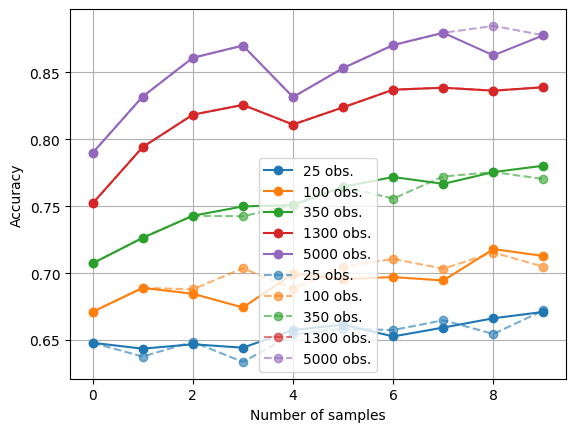

In [14]:
num_samples = np.sort(df_mean_samples.sample_n.unique())

threshold_fun = lambda x: 0.84 - 1.74 * x ** (- 0.43)
accuracy_per_sample_num = []
for n in num_samples:
    df = df_mean_samples[df_mean_samples.sample_n <= n]
    df_mean_agg = df.groupby(["realization_n", "num_obs"])[["real_values", "predicted_values"]].mean()
    df_mean_agg = df_mean_agg.reset_index(level=['num_obs'])
    df_mean_agg["predicted_values_th"] = df_mean_agg.apply(lambda row: (row["predicted_values"] > threshold_fun(row["num_obs"])).astype(float), axis=1)

    df_mean_agg["accuracy"] = df_mean_agg.apply(lambda row: np.mean(row["predicted_values_th"] == row["real_values"]), axis=1)
    accuracy_per_sample_num.append(df_mean_agg.groupby(["num_obs"]).accuracy.mean().to_dict())
# Conver the list of dicts to a dict of lists
accuracy_per_sample_num_adaptive = {k: [dic[k] for dic in accuracy_per_sample_num] for k in accuracy_per_sample_num[0]}

threshold = 0.75
accuracy_per_sample_num = []
for n in num_samples:
    df = df_mean_samples[df_mean_samples.sample_n <= n]
    df_mean_agg = df.groupby(["realization_n", "num_obs"])[["real_values", "predicted_values"]].mean()
    df_mean_agg["predicted_values_th"] = df_mean_agg["predicted_values"].apply(lambda x: (x > threshold).astype(float))

    accuracies = df_mean_agg.apply(lambda row: np.mean(row["predicted_values_th"] == row["real_values"]), axis=1).to_frame().groupby(["num_obs"]).mean()
    accuracy_per_sample_num.append(accuracies.to_dict()[0])
# Conver the list of dicts to a dict of lists
accuracy_per_sample_num_fixed = {k: [dic[k] for dic in accuracy_per_sample_num] for k in accuracy_per_sample_num[0]}

print("Used samples:", df_mean_samples.realization_n.max())

# Plot side by side the accuracy per sample number for the fixed and adaptive threshold
# Use similar colors for the same number of observations
# Here we define the colors manually in a numpy array
colors = np.array(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
for i, (num_obs, accuracies) in enumerate(accuracy_per_sample_num_fixed.items()):
    plt.plot(num_samples, accuracies, label=f"{num_obs} obs.", marker="o", color=colors[i])
for i, (num_obs, accuracies) in enumerate(accuracy_per_sample_num_adaptive.items()):
    plt.plot(num_samples, accuracies, "--", label=f"{num_obs} obs.", marker="o", color=colors[i], alpha=0.6)
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
# plt.legend()
plt.grid()
plt.show()

Used samples: 65


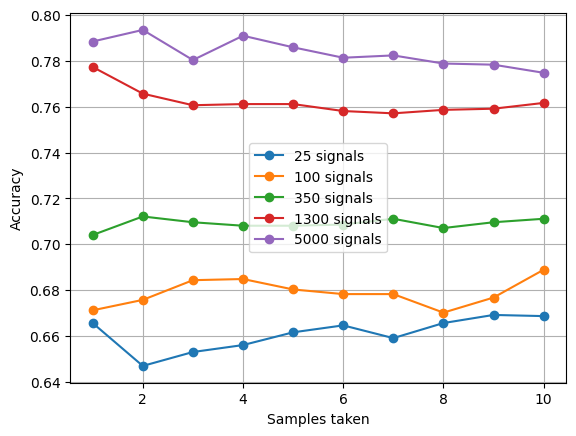

In [9]:
max_criterion = "log_posterior"

tuning_data = pd.read_csv("outputs/tuning_langevin.csv", sep=";", index_col=0)
tuning_data["accum_max_prob"] = tuning_data.groupby(["realization_n", "num_obs"])[max_criterion].cummax()
tuning_data["accum_accuracy"] = tuning_data['accuracy'].mask(tuning_data[max_criterion].lt(tuning_data['accum_max_prob'])).ffill()
agg_data = tuning_data.groupby(["num_obs", "sample_n"]).accum_accuracy.mean().to_frame()
plot_results = {num_obs: agg_data.loc[num_obs].accum_accuracy.values for num_obs in agg_data.index.get_level_values("num_obs").unique()}

print("Used samples:", tuning_data.realization_n.max())
# Plot a curve for each num_obs
num_samples = tuning_data.sample_n.unique()
for num_obs in plot_results.keys():
    plt.plot(num_samples + 1, plot_results[num_obs], marker="o", label=f"{num_obs} signals")
plt.xlabel("Samples taken")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


In [6]:
# tuning_data = pd.read_csv("outputs/tuning_langevin.csv", sep=";")
# print("Number of runs:", tuning_data.groupby(["num_obs", "epsilon"]).size().unique())

# tuning_data = tuning_data.groupby(["num_obs", "epsilon"]).accuracy.mean().to_frame()

# num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
# max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# for num_obs in num_obs_list:
#     axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, marker="o", label=f"{num_obs} observations")
# axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")
# # axs[1].plot(num_obs_list, 13.28 / (68.07 * np.log(num_obs_list) + 141.0) - 0.015, label="Homographic fit")
# # axs[1].plot(num_obs_list, - 0.00325 * np.log(num_obs_list) + 0.03, label="Linear fit")
# # axs[0].set_xscale("log")
# axs[0].set_xlabel("Epsilon")
# axs[0].set_ylabel("Accuracy")
# axs[0].legend()
# axs[1].set_xscale("log")
# axs[1].set_xlabel("Number of observations")
# axs[1].set_ylabel("Optimal epsilon")
# plt.show()

0.21737326846826352 -0.2987149043562974 0.8238265780644822


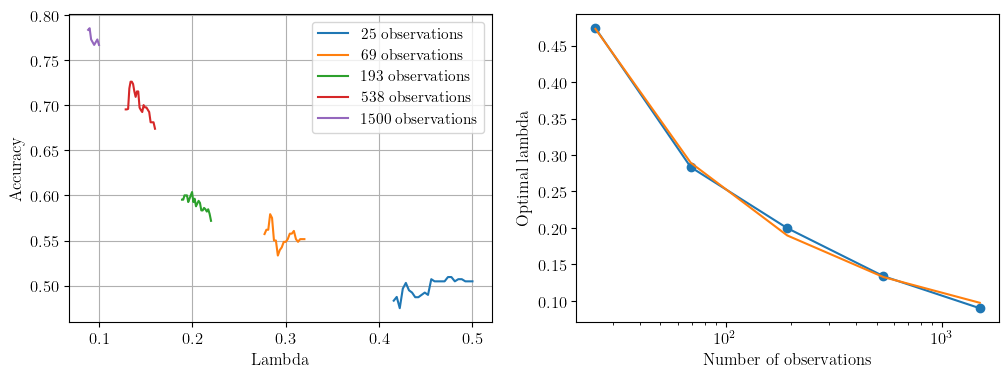

In [94]:
tuning_data = pd.read_csv("outputs/tuning_clime_ergm.csv", sep=";")
tuning_data = tuning_data.dropna()

grouped_tuning = tuning_data.groupby(["num_obs", "lambda"]).size()
filtered_idxs = grouped_tuning[grouped_tuning >= 0.5 * grouped_tuning.max()].index
tuning_data = tuning_data.groupby(["num_obs", "lambda"]).accuracy.mean().loc[filtered_idxs].to_frame()

# tuning_data = tuning_data.groupby(["num_obs", "lambda"]).accuracy.mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, "-", label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")

def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="New fit")
print(*popt)
# axs[1].plot(num_obs_list, 13.28 / (68.07 * np.log(num_obs_list) + 141.0) - 0.015, label="Homographic fit")
# axs[1].plot(num_obs_list, 1 / (-0.09569316 * np.log(num_obs_list)**2 + 21.02993316 * np.log(num_obs_list) - 37.3193769), label="Linear fit")
# axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid()
# axs[0].set_xticks(np.linspace(0.05, 0.6, 12))
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

In [69]:
5001-950

4051

13.0
0.3789016275896067 -1.976202816919137 4.841426065747745


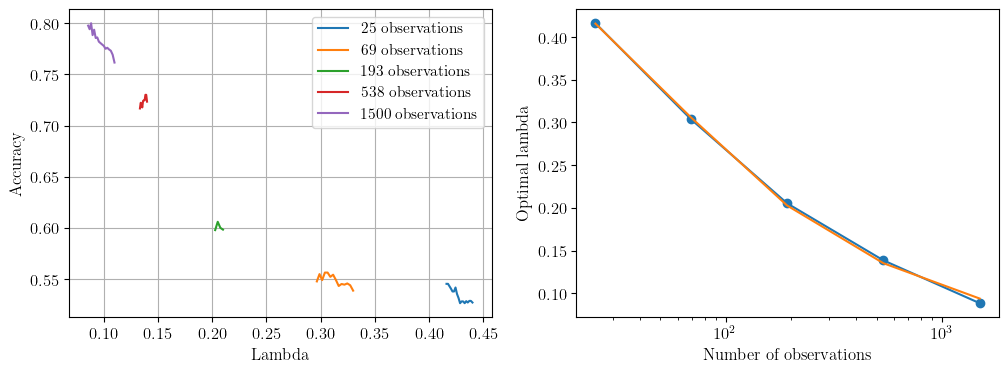

In [70]:
tuning_data = pd.read_csv("outputs/tuning_clime_barabasi.csv", sep=";")
tuning_data = tuning_data.dropna()
grouped_tuning = tuning_data.groupby(["num_obs", "lambda"]).size()
print(0.5 * grouped_tuning.max())
filtered_idxs = grouped_tuning[grouped_tuning >= 0.5 * grouped_tuning.max()].index
tuning_data = tuning_data.groupby(["num_obs", "lambda"]).accuracy.mean().loc[filtered_idxs].to_frame()
# tuning_data = tuning_data[tuning_data["num_obs"] == 1500]

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")

def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="New fit")
print(*popt)
# axs[1].plot(num_obs_list, 13.28 / (68.07 * np.log(num_obs_list) + 141.0) - 0.015, label="Homographic fit")
# axs[1].plot(num_obs_list, 1 / (-0.09569316 * np.log(num_obs_list)**2 + 21.02993316 * np.log(num_obs_list) - 37.3193769), label="Linear fit")
# axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
# axs[0].set_xticks(np.linspace(0.05, 0.6, 12))
axs[0].grid()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

In [37]:
tuning_data.loc[1500]

,accuracy
lambda,
0.090321,0.795699
0.093337,0.794444
0.096454,0.797101
0.099676,0.798039
0.103005,0.795152
0.106445,0.786310
0.110000,0.774269


0.2626951992800001 -0.870921809050705 2.8261108141978832


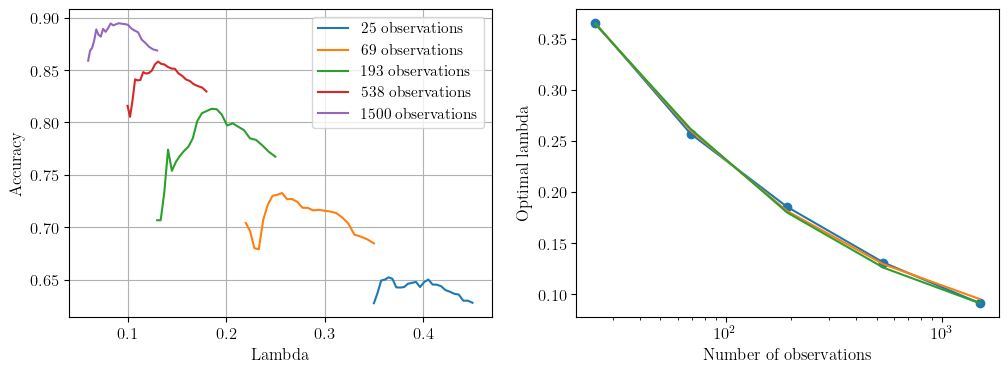

In [66]:
tuning_data = pd.read_csv("outputs/tuning_clime_deezer.csv", sep=";")
tuning_data = tuning_data.dropna()
tuning_data = tuning_data.groupby(["num_obs", "lambda"]).accuracy.mean().to_frame()
# grouped_tuning = tuning_data.groupby(["num_obs", "lambda"]).size()
# filtered_idxs = grouped_tuning[grouped_tuning >= 0.5 * grouped_tuning.max()].index
# tuning_data = tuning_data.groupby(["num_obs", "lambda"]).accuracy.mean().loc[filtered_idxs].to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")

def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="New fit")
axs[1].plot(num_obs_list, func(num_obs_list, 0.307708983304954, -1.2323776314123278, 3.525991208936651))
print(*popt)
# axs[1].plot(num_obs_list, 13.28 / (68.07 * np.log(num_obs_list) + 141.0) - 0.015, label="Homographic fit")
# axs[1].plot(num_obs_list, 1 / (-0.09569316 * np.log(num_obs_list)**2 + 21.02993316 * np.log(num_obs_list) - 37.3193769), label="Linear fit")
# axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
# axs[0].set_xticks(np.linspace(0.05, 0.6, 12))
axs[0].grid()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

1.8264768735100902 1.8698450775637432 -2.7162856574826684


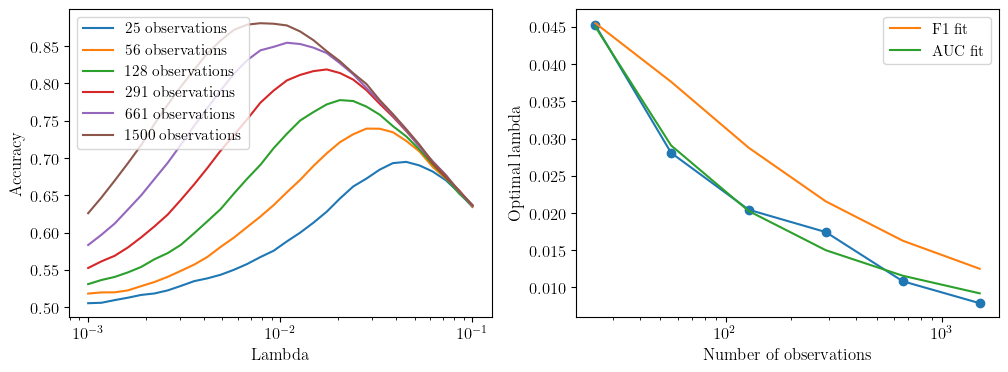

In [7]:
tuning_data = pd.read_csv("outputs/tuning_glasso_deezer_all_missing.csv", sep=";")
metric = "auc"

tuning_data = tuning_data.groupby(["num_obs", "lambda"])[metric].mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)[metric].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs][metric].index, tuning_data.loc[num_obs][metric].values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")

def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
print(*popt)
axs[1].plot(num_obs_list, func(num_obs_list, *[2.573102142950813, -12.93716156831535, 36.96659007232179]), label="F1 fit")
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="AUC fit")

axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
axs[1].legend()
plt.show()

0.42983989564100067 -1.7703947141375826 4.44788669102307


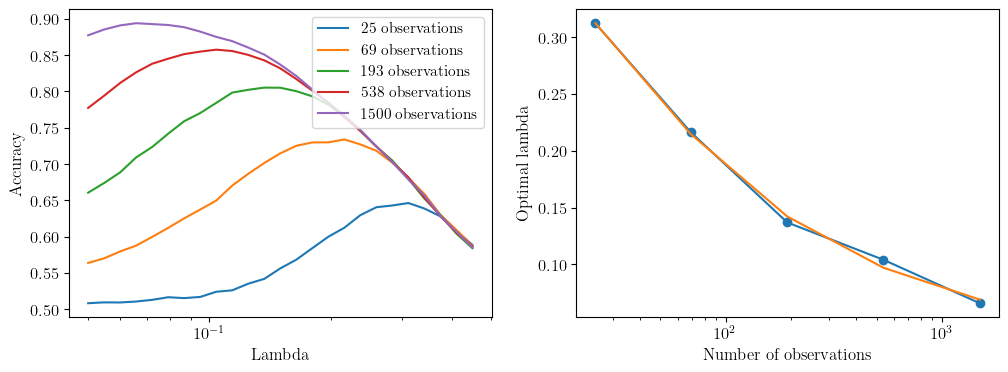

In [6]:
tuning_data = pd.read_csv("outputs/tuning_clime_deezer_all_missing.csv", sep=";")
metric = "auc"

tuning_data = tuning_data.groupby(["num_obs", "lambda"])[metric].mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)[metric].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs][metric].index, tuning_data.loc[num_obs][metric].values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")

def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
print(*popt)
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="New fit")

axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

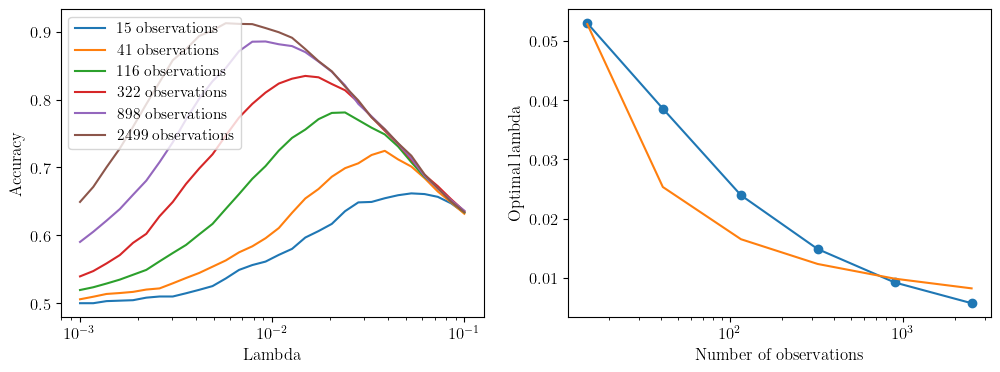

In [39]:
tuning_data = pd.read_csv("outputs/tuning_glasso_deezer.csv", sep=";").groupby(["num_obs", "lambda"]).accuracy.mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")
# axs[1].plot(num_obs_list, 13.28 / (68.07 * np.log(num_obs_list) + 141.0) - 0.015, label="Homographic fit")
axs[1].plot(num_obs_list, 1 / (-0.09569316 * np.log(num_obs_list)**2 + 21.02993316 * np.log(num_obs_list) - 37.3193769))
axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

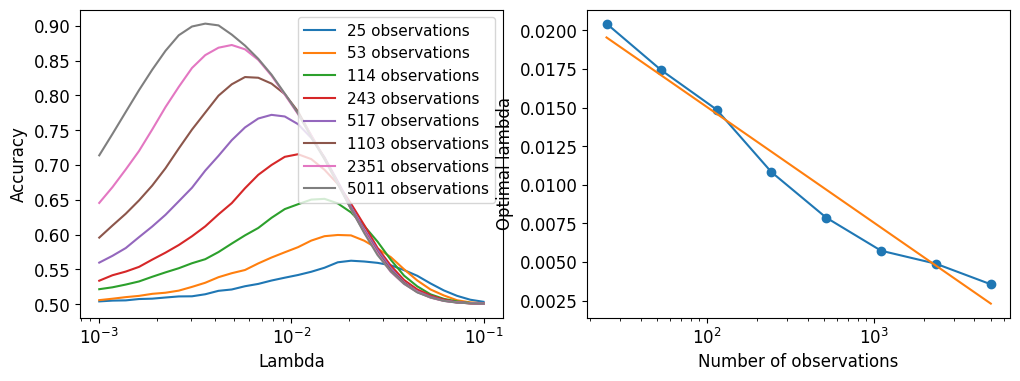

In [36]:
tuning_data = pd.read_csv("outputs/tuning_glasso_ergm.csv", sep=";").groupby(["num_obs", "lambda"]).accuracy.mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")
# axs[1].plot(num_obs_list, 13.28 / (68.07 * np.log(num_obs_list) + 141.0) - 0.015, label="Homographic fit")
axs[1].plot(num_obs_list, - 0.00325 * np.log(num_obs_list) + 0.03, label="Linear fit")
axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

4.873667059388465 -19.52066550399929 48.028925499271914


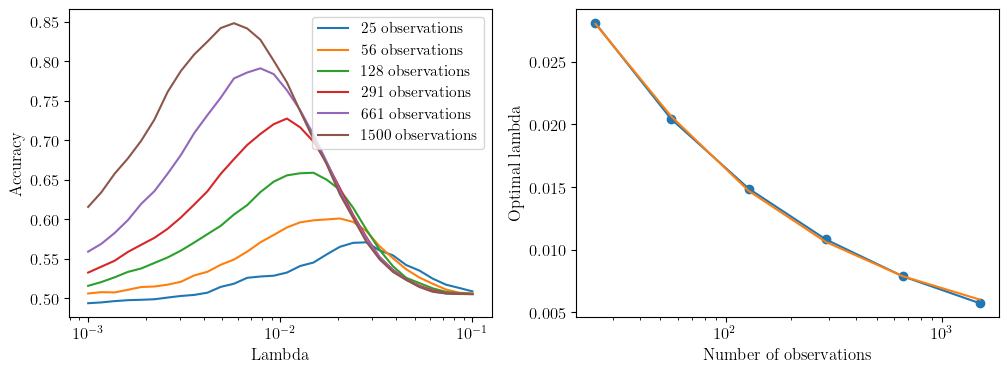

In [120]:
tuning_data = pd.read_csv("outputs/tuning_glasso_grids.csv", sep=";").groupby(["num_obs", "lambda"]).accuracy.mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")
def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
print(*popt)
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="New fit")
axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
plt.show()

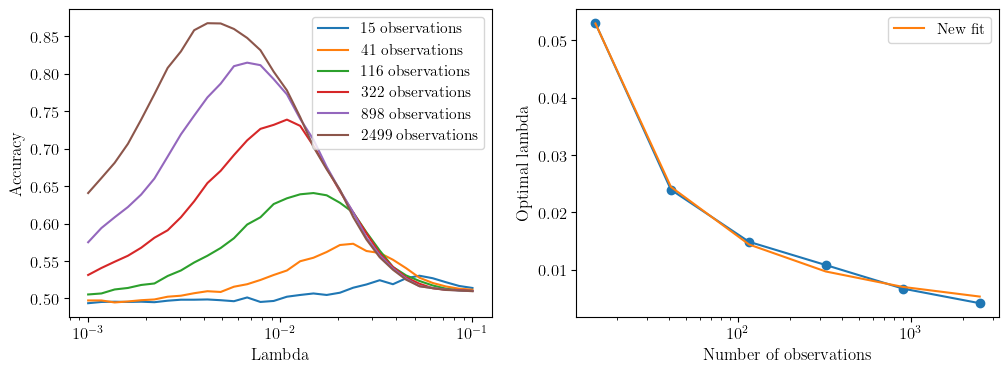

[  2.69135693   4.61820941 -13.35200138]


In [5]:
tuning_data = pd.read_csv("outputs/tuning_glasso_ergm.csv", sep=";").groupby(["num_obs", "lambda"]).accuracy.mean().to_frame()

num_obs_list = tuning_data.index.get_level_values("num_obs").unique()
max_per_num_obs = tuning_data.groupby(level=0)['accuracy'].idxmax().apply(lambda x: x[1])

def func(x, a, b, c):
    return 1 / (a * np.log(x)**2 + b * np.log(x) + c)

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for num_obs in num_obs_list:
    axs[0].plot(tuning_data.loc[num_obs].accuracy.index, tuning_data.loc[num_obs].accuracy.values, label=f"{num_obs} observations")
axs[1].plot(max_per_num_obs.index, max_per_num_obs.values, marker="o")
axs[1].plot(num_obs_list, func(num_obs_list, *popt), label="New fit")
# axs[1].plot(num_obs_list, previous_lambda_fun(num_obs_list), label="Previous fit")
axs[0].set_xscale("log")
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of observations")
axs[1].set_ylabel("Optimal lambda")
axs[1].legend()
plt.show()
print(popt)

In [14]:
# Curve fitting
def func(x, a, b):
    return a * np.log(x) + b

popt, pcov = curve_fit(func, max_per_num_obs.index, max_per_num_obs.values)
print(popt)

[-0.00331876  0.03018365]


In [15]:
# plt.plot(tracks_noncvx)
# plt.show()

#### Gradients

In [40]:
import cvxpy as cp

U_idxs_triu = np.where(np.isnan(np.triu(A_obs)))
M_mask = ~ np.isnan(A_obs)
S = np.cov(X_obs, rowvar=False, ddof=0)
random_init = np.random.normal(0.5, 0.5, size=(num_nodes, num_nodes))
A_tilde = np.tril(random_init) + np.tril(random_init, -1).T
np.fill_diagonal(A_tilde, 0.0)
A_tilde[M_mask] = A_obs[M_mask]

# Raw estimator for Theta
A_mask = (1 - ((A_obs + I) == 0).astype(int))
Theta_cp = cp.Variable((num_nodes, num_nodes), PSD=True)
obj = cp.Maximize(cp.log_det(cp.multiply(Theta_cp, A_mask)) - cp.trace(S @ cp.multiply(Theta_cp, A_mask)))
# constr = [Theta_cp[np.where(A_nan == 0)] == 0.0]
# prob = cp.Problem(obj, constr)
prob = cp.Problem(obj)
prob.solve()
Theta_est = Theta_cp.value * A_mask

In [51]:
# Gradient with NumPy and Matrix Cookbook

cov_inv = Theta_est * (A_tilde + I)
cov = np.linalg.inv(cov_inv)
aux_matrix = - np.diag(np.diag(cov)) + 2 * cov - 2 * S + np.diag(np.diag(S))
delta_mrf = num_obs * aux_matrix[U_idxs_triu] * Theta_est[U_idxs_triu] * 0.5
print("Manual gradient:", delta_mrf)

Manual gradient: [32.56295672  0.01531946 -1.31263531 21.54056645]


In [48]:
# Gradient with PyTorch
Theta_est_torch = torch.tensor(Theta_est, requires_grad=False)
I_torch = torch.eye(num_nodes)
S_torch = torch.tensor(S, requires_grad=False)

A_torch_original = torch.tensor(A_tilde, requires_grad=True)
A_torch = torch.triu(A_torch_original) + torch.triu(A_torch_original, diagonal=1).T
Theta_torch = Theta_est_torch * (A_torch + I_torch)
likelihood = num_obs * 0.5 * (torch.logdet(Theta_torch) - torch.trace(S_torch @ (Theta_torch)))
torch_grad = torch.autograd.grad(likelihood, A_torch_original)[0].numpy()
print("Torch gradient:", torch_grad[U_idxs_triu])

Torch gradient: [32.56295672  0.01531946 -1.31263531 21.54056645]
